### Import Required Libraries

In [1]:
import os
import numpy as np
import pandas as pd
# Pandas Options 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandas.io.json import json_normalize

import json
import requests
import re
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

%matplotlib inline

import seaborn as sns
# Seaborn Options
sns.set_theme()

import folium
from folium import plugins
from folium.plugins import HeatMap

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

print("Libraries Imported")

Libraries Imported


<h1 style="text-align: center">Battle of the Neighborhoods, Arlington County, Virginia Food Truck Locations</h1>

## Table of Contents

## A. Introduction

Over the course of the last decade food trucks have become increasingly popular across the United States, including in Arlington County, Virginia a suburb of Washington D.C., where the number of food trucks has seemingly increase greatly in recent years.  The mobility of food trucks is one of the reasons they are such a popular alternative to brick and mortar restaurants, as they are able to move location with ease to reach more patrons in different markets.  However, as the number of food trucks on the road has greatly increase it has become not too uncommon to see many food trucks crowding a single location, battling over prime real estate.  Some popular neighborhoods in Arlington experience this as food trucks gravitate to them.  For food trucks profitable locations are critical to their success and it is often not easy to branch out and discover new viable locations making known locations more desirable. 

This project is aimed towards food truck owners or managers in Arlington County, Virginia in order to explore what features successful neighborhoods for food trucks have and if there are any potential neighborhoods with similar feature and without any current food truck venues that would be make a viable option to explore business in.

## B. Data

### 1) Arlington Neighborhoods Demographics
Arlington County’s website https://arlingtonva.us has a projects section that includes data and research for topics such as Arlington’s demographics by geography.   Within the provide data Arlington County breaks down demographic information from the 2010 U.S. Census by neighborhood or civic association.  There are 61 pdfs documents containing the demographic break down, one for each of the neighborhoods determined by Arlington’s projects and planning.  Within the pdf documents the demographic data includes total population of the neighborhood, population broken down on race, age and sex, total households, households broken down by type and size and lastly the total housing units and rather they are rented or owned and occupied or not.  Overall from this data source a list Arlington neighborhood as well as their demographic makeup can be complied.

### 2) Arlington Neighborhoods Locations
Geopy https://geopy.readthedocs.io/en/stable/ is a python library which enables geographic coordinates to be attained from addresses, cities, countries, and landmarks.   This library will be utilized in order to coordinates of each of the Arlington neighborhoods. 

### 3) Four Square Venue Data
Four Square https://foursquare.com is a social networking service which provides an API with a feature that allows developers to find information about venues listed in their data that are nearby geographic coordinates.  The API will be used to find venues that are nearby each neighborhood in Arlington in order provide data on the venue composition of them.   

## C. Methodology

### 1) Construct Data Frame of Arlington Neighborhoods Demographics 

Demographics data directory

In [2]:
DIR_PATH = r'data/demographics/csv/'

List of Arlington Neighborhoods with Civic Association Demographics Data 

In [3]:
for i, file in enumerate(os.listdir(DIR_PATH)):
    print(i, "-", file)

0 - Alcova-Heights.csv
1 - Arlington-Forest.csv
2 - Arlington-Heights.csv
3 - Arlington-Ridge.csv
4 - Arlington-View.csv
5 - Arlingwood.csv
6 - Ashton-Heights.csv
7 - Aurora-Highlands.csv
8 - Ballston-VA-Square.csv
9 - Barcroft.csv
10 - Bellevue-Forest.csv
11 - Bluemont.csv
12 - Boulevard-Manor.csv
13 - Buckingham.csv
14 - Chain-Bridge-Forest.csv
15 - Cherry-Valley-Nature-Area.csv
16 - Cherrydale.csv
17 - Claremont.csv
18 - Clarendon-Courthouse.csv
19 - Colonial-Village.csv
20 - Columbia-Forest.csv
21 - Columbis-Heights-West.csv
22 - Columbis-Heights.csv
23 - Dominion-Hills.csv
24 - Donaldson-Run.csv
25 - Douglas-Park.csv
26 - Dover-Crystal.csv
27 - East-Falls-Church.csv
28 - Fairlington.csv
29 - Forest-Glen.csv
30 - Forest-Hills.csv
31 - Foxcroft-Heights.csv
32 - Glebewood.csv
33 - Glencarlyn.csv
34 - Gulf-Branch.csv
35 - Highland-Park-Overlee-Knolls.csv
36 - John-M-Langston.csv
37 - Leeway-Overlee.csv
38 - Long-Branch-Creek.csv
39 - Lyon-Park.csv
40 - Lyon-Village.csv
41 - Madison-Ma

Create an Arlington Demographic Data Frame from the csv files

In [4]:
# Define Function to load and process demographic csv
def process_demographic_csv(file_path):
    # 1. Read csv to pandas df, skip 2 rows, set column 0 as index
    df = pd.read_csv(file_path, skiprows=2, index_col=0)
    # 2. Drop last two columns (Arlington totals)
    df.drop(df.columns[-2:], axis=1, inplace=True)
    # 3. Convert percent column to floats
    df['Percent'] = df['Percent'].str.rstrip('%').astype('float') / 100.0
    # 4. Replace Total rows Percent with Number 
    df['Percent'].mask(df.index.str.contains('TOTAL'), df['Number'], inplace=True)
    # 5. Drop Number column 
    df.drop(columns=['Number'], inplace=True)
    # 6. Rename percent to neighborhood name
    df.columns = [df.index.name]
    df.index.name = None
    # 7. drop na 
    df.dropna(inplace=True)
    # 8. Transpose df
    df = df.T
    
    return df


# load and process all csv files in the data directory 
demographic_dfs = [process_demographic_csv(DIR_PATH+file) for file in os.listdir(DIR_PATH)]

# combine each all of the neighborhoods 
arlington_demographics = pd.concat(demographic_dfs)
# sort data frames index (neighborhood name) alphabetically
arlington_demographics.sort_index(inplace=True)
arlington_demographics

,TOTAL POPULATION,Total Non-Hispanic or Latino,White alone,Black or African-American alone,American Indian or Alaska Native alone,Asian alone,Native Hawaiian or Pacific Islander Alone,Some other Race alone,Two or more Races,Total Hispanic or Latino,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,Male,Female,TOTAL HOUSEHOLDS,Family households:,Husband-wife family,Other family:,"Male householder, no wife present","Female householder, no husband present",Nonfamily households:,Householder living alone,Householder not living alone,1-person household,2-person household,3-person household,4-person household,5-person household,6-person household,7-or-more-person household,TOTAL HOUSING UNITS,Occupied Housing Units,Owner-Occupied,Renter-Occupied,Vacant Housing Units
Alcova Heights,"1,900",0.761,0.582,0.047,0.003,0.097,0.000,0.003,0.029,0.239,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,0.490,0.510,745,0.580,0.474,0.106,0.030,0.077,0.420,0.278,0.142,0.278,0.340,0.168,0.106,0.064,0.019,0.026,784,0.950,0.696,0.254,0.050
Arlington Forest,"2,223",0.927,0.823,0.017,0.001,0.047,0.004,0.001,0.034,0.073,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.506,0.494,834,0.685,0.613,0.072,0.018,0.054,0.315,0.207,0.108,0.207,0.317,0.194,0.211,0.049,0.013,0.008,852,0.979,0.823,0.156,0.021
Arlington Heights,"2,555",0.770,0.576,0.060,0.002,0.101,0.003,0.004,0.025,0.230,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.499,0.501,"1,032",0.529,0.414,0.115,0.029,0.086,0.471,0.326,0.145,0.326,0.309,0.167,0.102,0.044,0.020,0.033,1070,0.964,0.595,0.369,0.036
Arlington Ridge,"6,324",0.937,0.733,0.040,0.003,0.132,0.001,0.002,0.027,0.063,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.479,0.521,"3,549",0.352,0.313,0.039,0.012,0.026,0.648,0.492,0.156,0.492,0.343,0.090,0.051,0.016,0.006,0.002,3755,0.945,0.416,0.529,0.055
Arlington View,979,0.896,0.190,0.619,0.012,0.057,0.001,0.001,0.015,0.104,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.487,0.513,376,0.598,0.298,0.301,0.077,0.223,0.402,0.287,0.114,0.287,0.309,0.165,0.122,0.056,0.029,0.032,391,0.962,0.517,0.445,0.038
Arlingwood,366,0.959,0.888,0.019,0.005,0.025,0.000,0.008,0.014,0.041,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.478,0.522,136,0.809,0.750,0.059,0.029,0.029,0.191,0.162,0.029,0.162,0.382,0.140,0.243,0.066,0.007,0.000,148,0.919,0.851,0.068,0.081
Ashton Heights,"3,962",0.856,0.685,0.063,0.001,0.082,0.000,0.003,0.022,0.144,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,0.521,0.479,"1,715",0.451,0.363,0.087,0.027,0.060,0.549,0.362,0.188,0.362,0.304,0.152,0.122,0.036,0.017,0.007,1777,0.965,0.385,0.580,0.035
Aurora Highlands,"8,725",0.907,0.680,0.082,0.003,0.113,0.000,0.001,0.028,0.093,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.491,0.509,"4,804",0.297,0.255,0.042,0.012,0.030,0.703,0.507,0.196,0.507,0.326,0.095,0.050,0.014,0.006,0.003,5514,0.871,0.124,0.747,0.129
Ballston - Virginia Square,"13,753",0.948,0.773,0.029,0.001,0.118,0.000,0.002,0.025,0.052,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,0.502,0.498,"8,218",0.240,0.203,0.038,0.014,0.023,0.760,0.514,0.245,0.514,0.363,0.083,0.031,0.007,0.001,0.001,8861,0.927,0.329,0.598,0.073
Barcroft,"3,477",0.632,0.497,0.050,0.002,0.057,0.001,0.003,0.022,0.368,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.529,0.471,"1,285",0.602,0.461,0.141,0.068,0.073,0.398,0.267,0.131,0.267,0.282,0.163,0.168,0.065,0.031,0.024,1327,0.968,0.518,0.451,0.032


Drop Race/Ethicity, Sex, Household Subtypes, Household Size Demographics

In [5]:
# Columns to keep
columns = [
    'TOTAL POPULATION',
    'Under 5 years',
    '5 to 17 years',
    '18 to 24 years',
    '25 to 34 years',
    '35 to 44 years',
    '45 to 54 years',
    '55 to 64 years',
    '65 to 74 years',
    '75 to 84 years',
    '85 years and over',
    'TOTAL HOUSEHOLDS',
    'Family households:',
    'Nonfamily households:',
    'TOTAL HOUSING UNITS',
    'Occupied Housing Units',
    'Vacant Housing Units',
]
arlington_demographics = arlington_demographics[columns].copy()
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,Family households:,Nonfamily households:,TOTAL HOUSING UNITS,Occupied Housing Units,Vacant Housing Units
Alcova Heights,"1,900",0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,"2,223",0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,"2,555",0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,"1,032",0.529,0.471,1070,0.964,0.036
Arlington Ridge,"6,324",0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,"3,549",0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,"3,962",0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,"1,715",0.451,0.549,1777,0.965,0.035
Aurora Highlands,"8,725",0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,"4,804",0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,"13,753",0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,"8,218",0.240,0.760,8861,0.927,0.073
Barcroft,"3,477",0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,"1,285",0.602,0.398,1327,0.968,0.032


Rename Columns

In [6]:
arlington_demographics.rename(columns={"Family households:": "family households", 
                                       "Nonfamily households:": "nonfamily households",
                                       "Nonfamily households:": "nonfamily households",
                                       "Occupied Housing Units": "occupied housing units",
                                       "Vacant Housing Units": "vacant housing units"
                                      }, inplace=True)

Convert 'Total' Columns from string types to integers 

In [7]:
arlington_demographics['TOTAL POPULATION'] = arlington_demographics['TOTAL POPULATION'].str.replace(',', '').astype('int')
arlington_demographics['TOTAL HOUSEHOLDS'] = arlington_demographics['TOTAL HOUSEHOLDS'].str.replace(',', '').astype('int')
arlington_demographics['TOTAL HOUSING UNITS'] = arlington_demographics['TOTAL HOUSING UNITS'].str.replace(',', '').astype('int')
arlington_demographics

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units
Alcova Heights,1900,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050
Arlington Forest,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021
Arlington Heights,2555,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,1032,0.529,0.471,1070,0.964,0.036
Arlington Ridge,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055
Arlington View,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038
Arlingwood,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081
Ashton Heights,3962,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,1715,0.451,0.549,1777,0.965,0.035
Aurora Highlands,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129
Ballston - Virginia Square,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073
Barcroft,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032


In [8]:
arlington_demographics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61 entries, Alcova Heights to Yorktown
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   TOTAL POPULATION        61 non-null     int64 
 1   Under 5 years           61 non-null     object
 2   5 to 17 years           61 non-null     object
 3   18 to 24 years          61 non-null     object
 4   25 to 34 years          61 non-null     object
 5   35 to 44 years          61 non-null     object
 6   45 to 54 years          61 non-null     object
 7   55 to 64 years          61 non-null     object
 8   65 to 74 years          61 non-null     object
 9   75 to 84 years          61 non-null     object
 10  85 years and over       61 non-null     object
 11  TOTAL HOUSEHOLDS        61 non-null     int64 
 12  family households       61 non-null     object
 13  nonfamily households    61 non-null     object
 14  TOTAL HOUSING UNITS     61 non-null     int64 

### 2) Get Coordinates of Arlington County, Virginia 

In [9]:
# get arlington county lat & long

address = 'Arlington County, Virginia'

geolocator = Nominatim(user_agent="my_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

### 3) Fetch Coordinates for each of the Arlington Neighborhoods

In [10]:
def fetch_location(neigh):
    address = neigh + ', Arlington County, Virginia'
    geolocator = Nominatim(user_agent="my_explorer")
    location = geolocator.geocode(address)
    return location

# Define Columns 
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe 
arlington_neighborhoods_location = pd.DataFrame(columns=column_names)

for i, n in enumerate(arlington_demographics.index):
    if '/' in n or '-' in n:
        s = re.split('/|-', n)
        sum_lat, sum_long, cnt = 0, 0, 0
        # if two or more neighborhoods are combined take the midpoint
        for _n in s:
            location = fetch_location(_n)
            lat, long = (location.latitude, location.longitude) if location else (None, None)
            if(lat and long):
                cnt += 1
                sum_lat += lat
                sum_long += long
        lat, long = sum_lat/cnt if sum_lat != 0 else np.nan , sum_long/cnt if sum_long != 0 else np.nan 

    else:
        location = fetch_location(n)
        lat, long = (location.latitude, location.longitude) if location else (np.nan, np.nan)
        
    arlington_neighborhoods_location.loc[i] = [n, lat, long]
arlington_neighborhoods_location

,Neighborhood,Latitude,Longitude
0,Alcova Heights,38.864557,-77.097201
1,Arlington Forest,38.868856,-77.113084
2,Arlington Heights,38.869557,-77.092201
3,Arlington Ridge,38.890396,-77.084159
4,Arlington View,38.863079,-77.072591
5,Arlingwood,38.927611,-77.121923
6,Ashton Heights,38.894628,-77.077531
7,Aurora Highlands,38.859493,-77.061664
8,Ballston - Virginia Square,38.882475,-77.107412
9,Barcroft,38.855946,-77.103868


Neighborhoods without coordinate data

In [11]:
arlington_neighborhoods_location[arlington_neighborhoods_location.isna().any(axis=1)]

,Neighborhood,Latitude,Longitude
15,Cherry Valley Nature Area,NaN,NaN
36,John M Langston,NaN,NaN
37,Leeway Overlee,NaN,NaN
54,Tara Leeway Heights,NaN,NaN
55,Waverly Hills,NaN,NaN


Manually Edit Location Data For Missing or Incorrect Coordinates (from google maps) 

In [12]:
location_patches = [
['Arlington Ridge', 38.85357, -77.06798],
['Ashton Heights', 38.87615, -77.10072],
['Aurora Highlands', 38.85420, -77.06106],
['Barcroft', 38.86201, -77.11044],
['Bluemont', 38.87823, -77.12106],
['Boulevard Manor', 38.87007, -77.13587],
['Buckingham', 38.87216, -77.10995],
['Cherrydale', 38.87216, -77.10872],
['Donaldson Run', 38.90617, -77.11617],
['Forest Glen', 38.85914, -77.12141],
['Forest Hills', 38.86952, -77.11799],
['Old Dominion', 38.90011, -77.12456],
['Old Glebe', 38.92017, -77.12938],
['Rock Spring', 38.91049, -77.14109],
['Waverly Hills', 38.89593, -77.11817],
['Williamsburg', 38.90016, -77.15657]]

for l in location_patches:
    arlington_neighborhoods_location.loc[(arlington_neighborhoods_location.Neighborhood == l[0]), ['Latitude', 'Longitude']] = l[1:]
arlington_neighborhoods_location.set_index('Neighborhood', inplace=True)
arlington_neighborhoods_location

,Latitude,Longitude
Neighborhood,,
Alcova Heights,38.864557,-77.097201
Arlington Forest,38.868856,-77.113084
Arlington Heights,38.869557,-77.092201
Arlington Ridge,38.853570,-77.067980
Arlington View,38.863079,-77.072591
Arlingwood,38.927611,-77.121923
Ashton Heights,38.876150,-77.100720
Aurora Highlands,38.854200,-77.061060
Ballston - Virginia Square,38.882475,-77.107412


Drop All remaining Neighborhoods without location data 

In [13]:
arlington_neighborhoods_location.dropna(inplace=True)
arlington_neighborhoods_location

,Latitude,Longitude
Neighborhood,,
Alcova Heights,38.864557,-77.097201
Arlington Forest,38.868856,-77.113084
Arlington Heights,38.869557,-77.092201
Arlington Ridge,38.853570,-77.067980
Arlington View,38.863079,-77.072591
Arlingwood,38.927611,-77.121923
Ashton Heights,38.876150,-77.100720
Aurora Highlands,38.854200,-77.061060
Ballston - Virginia Square,38.882475,-77.107412


Map of Alrington with Neighborhoods Superimposed

In [14]:
map_arlington = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, neighborhood in zip(arlington_neighborhoods_location['Latitude'], arlington_neighborhoods_location['Longitude'], arlington_neighborhoods_location.index):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_arlington)
    

map_arlington

### 4) Use the FourSquare API to Find Venues Nearby Each of the Neighborhoods

Define FourSquare Credentials & Env

In [15]:
from four_square_config import FS_CLIENT_ID, FS_CLIENT_SECRET, FS_ACCESS_TOKEN

CLIENT_ID = FS_CLIENT_ID # os.environ.get("FS_CLIENT_ID")
CLIENT_SECRET = FS_CLIENT_SECRET # os.environ.get("FS_CLIENT_SECRET")
ACCESS_TOKEN = FS_ACCESS_TOKEN # os.environ.get("FS_ACCESS_TOKEN")

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value (limit to 100 nearby venues)

Function to fetch Nearby Venues from FourSquare

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=400):
    """Nearby defaults to 400 meters"""
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        
        # API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        # GET
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        print(name, "- Venues Found: ", len(results))
        
        # return list of relevant info for each venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    return venues_list

Fetch list of nearby each of the neighborhoods and create data frame

In [17]:
nearby_venues_list = getNearbyVenues(names=arlington_neighborhoods_location.index, 
                                   latitudes=arlington_neighborhoods_location['Latitude'], 
                                   longitudes=arlington_neighborhoods_location['Longitude'])

nearby_venues = pd.DataFrame([item for venue_list in nearby_venues_list for item in venue_list])
nearby_venues.columns = ['Neighborhood', 
                            'Neighborhood_Latitude', 
                            'Neighborhood_Longitude',
                            'Venue', 
                            'Venue_Latitude', 
                            'Venue_Longitude', 
                            'Venue_Category']

Alcova Heights - Venues Found:  2
Arlington Forest - Venues Found:  7
Arlington Heights - Venues Found:  6
Arlington Ridge - Venues Found:  4
Arlington View - Venues Found:  2
Arlingwood - Venues Found:  2
Ashton Heights - Venues Found:  0
Aurora Highlands - Venues Found:  4
Ballston - Virginia Square - Venues Found:  43
Barcroft - Venues Found:  3
Bellevue Forest - Venues Found:  2
Bluemont - Venues Found:  12
Boulevard Manor - Venues Found:  4
Buckingham - Venues Found:  4
Chain Bridge Forest - Venues Found:  1
Cherrydale - Venues Found:  11
Claremont - Venues Found:  12
Clarendon-Courthouse - Venues Found:  43
Colonial Village - Venues Found:  39
Columbia Forest - Venues Found:  16
Columbia Heights - Venues Found:  3
Columbia Heights West - Venues Found:  3
Dominion Hills - Venues Found:  12
Donaldson Run - Venues Found:  0
Douglas Park - Venues Found:  3
Dover Crystal - Venues Found:  0
East Falls Church - Venues Found:  5
Fairlington - Venues Found:  6
Forest Glen - Venues Found: 

In [18]:
nearby_venues

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Alcova Heights,38.864557,-77.097201,Ruthie’s All Day,38.867434,-77.095350,American Restaurant
1,Alcova Heights,38.864557,-77.097201,Boiler,38.865986,-77.098739,American Restaurant
2,Arlington Forest,38.868856,-77.113084,Crystal Thai,38.867608,-77.117250,Thai Restaurant
3,Arlington Forest,38.868856,-77.113084,Subway,38.867888,-77.116996,Sandwich Place
4,Arlington Forest,38.868856,-77.113084,Arlington Forest Shopping Center,38.867699,-77.117069,Shopping Mall
5,Arlington Forest,38.868856,-77.113084,Bricks Pizza,38.867880,-77.117216,Pizza Place
6,Arlington Forest,38.868856,-77.113084,Sense of Place Café,38.867880,-77.117216,Café
7,Arlington Forest,38.868856,-77.113084,Fiesta Oriental Market,38.867671,-77.117141,Grocery Store
8,Arlington Forest,38.868856,-77.113084,Henry Wright Park,38.871618,-77.110371,Park
9,Arlington Heights,38.869557,-77.092201,Ruthie’s All Day,38.867434,-77.095350,American Restaurant


In [19]:
nearby_venues.shape

(501, 7)

### 5) Get Data Frame of Food Truck Venues Nearby Neighborhoods

In [20]:
nearby_food_trucks = nearby_venues[nearby_venues['Venue_Category'] == 'Food Truck']
nearby_food_trucks

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
56,Ballston - Virginia Square,38.882475,-77.107412,Willie's Po' Boy Truck,38.881614,-77.111602,Food Truck
173,Colonial Village,38.892392,-77.080983,"Tacos ""El Chilango""",38.890531,-77.077326,Food Truck
178,Colonial Village,38.892392,-77.080983,La Tingeria,38.891447,-77.084740,Food Truck
189,Colonial Village,38.892392,-77.080983,Chef On Wheels,38.891131,-77.083711,Food Truck
192,Colonial Village,38.892392,-77.080983,Tacos Matadores,38.891355,-77.084813,Food Truck
199,Colonial Village,38.892392,-77.080983,Red Hook Lobster Pound,38.891478,-77.085015,Food Truck
243,Fairlington,38.832971,-77.090225,Pepe Food Truck [José Andrés],38.834806,-77.086521,Food Truck
309,Long Branch Creek,38.849831,-77.074681,Rocklands BBQ Food Truck,38.849620,-77.074201,Food Truck
319,Lyon Park,38.880436,-77.089853,Puddin',38.881925,-77.085785,Food Truck
335,Lyon Park,38.880436,-77.089853,K-BBQ Taco Box FoodTruck By Chef.Eric,38.882149,-77.085954,Food Truck


Drop Food Truck Venues from the Venues Data Frame

In [21]:
#arlington_neighborhood_venues.drop(arlington_neighborhood_venues[arlington_neighborhood_venues['Venue_Category'] == 'Food Truck'].index, inplace=True)

Map of Arlington with Food Truck Venues Superimposed 

In [22]:
map_food_trucks = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, venue in zip(nearby_food_trucks['Venue_Latitude'], nearby_food_trucks['Venue_Longitude'], nearby_food_trucks['Venue']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_food_trucks)
    

map_food_trucks

Count the Number of Food Trucks Near Neighborhood

In [23]:
nearby_food_truck_count = nearby_food_trucks.groupby('Neighborhood').agg({'Venue':'count'}).rename(columns={'Venue':'Food Truck Count'})
nearby_food_truck_count

,Food Truck Count
Neighborhood,
Ballston - Virginia Square,1
Colonial Village,5
Fairlington,1
Long Branch Creek,1
Lyon Park,2
Waycroft-Woodlawn,2


### 6) Explore Nearby Venue Categories 

Check how many unique venues were found, venues can be nearby multiple neighborhoods

In [24]:
print('There are {} uniques categories and {} unique Venues.'
      .format(len(nearby_venues['Venue_Category'].unique()), 
              len(nearby_venues['Venue'].unique())))

There are 153 uniques categories and 411 unique Venues.


List Venue Categories and their number of occurances 

In [25]:
nearby_venues['Venue_Category'].value_counts()

Park                                        28
Pizza Place                                 17
Coffee Shop                                 16
Convenience Store                           13
Sandwich Place                              12
Gym                                         12
Food Truck                                  12
Trail                                       12
Pharmacy                                    11
Pool                                        11
Chinese Restaurant                          10
Mexican Restaurant                          10
Bar                                          9
Café                                         9
American Restaurant                          9
Bank                                         9
Middle Eastern Restaurant                    8
Gym / Fitness Center                         8
Hotel                                        8
Grocery Store                                8
Playground                                   7
Shopping Mall

Due to there being many venue categories with a small amount of occurrences, the majority having 2 or less, it would be in our favor to generalize the categories into broader groups 

#### Generalize Venue Categories 

The FourSquare documentation contains a basic grouping of venue categories that can be leverage in order to create a more general grouping 

Scrape Venue Category Groupings from the FourSquare Docs

In [26]:
URL = r'https://developer.foursquare.com/docs/build-with-foursquare/categories/'


page = requests.get(URL)
soup = BeautifulSoup(page.text, 'html.parser')

def get_sub_categories(foobar):
    sub_list = foobar.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
    sub_categories = [sub.find('h3').text for sub in sub_list.findAll('li', recursive=True)]
    return sub_categories

ul = soup.find('ul',  {'class': 'VenueCategories__Wrapper-sc-1ysxg0y-0 dikXMT'})
general_categories = ul.findAll('li', recursive=False)
general_venue_categories = {gen.find('h3').text: get_sub_categories(gen) for gen in general_categories}

general_venue_categories

{'Arts & Entertainment': ['Amphitheater',
  'Aquarium',
  'Arcade',
  'Art Gallery',
  'Bowling Alley',
  'Casino',
  'Circus',
  'Comedy Club',
  'Concert Hall',
  'Country Dance Club',
  'Disc Golf',
  'Exhibit',
  'General Entertainment',
  'Go Kart Track',
  'Historic Site',
  'Karaoke Box',
  'Laser Tag',
  'Memorial Site',
  'Mini Golf',
  'Movie Theater',
  'Drive-in Theater',
  'Indie Movie Theater',
  'Multiplex',
  'Museum',
  'Art Museum',
  'Erotic Museum',
  'History Museum',
  'Planetarium',
  'Science Museum',
  'Music Venue',
  'Jazz Club',
  'Piano Bar',
  'Rock Club',
  'Pachinko Parlor',
  'Performing Arts Venue',
  'Dance Studio',
  'Indie Theater',
  'Opera House',
  'Theater',
  'Pool Hall',
  'Public Art',
  'Outdoor Sculpture',
  'Street Art',
  'Racecourse',
  'Racetrack',
  'Roller Rink',
  'Salsa Club',
  'Samba School',
  'Stadium',
  'Baseball Stadium',
  'Basketball Stadium',
  'Cricket Ground',
  'Football Stadium',
  'Hockey Arena',
  'Rugby Stadium',
  

Replace the Venue Categories in the venue dataframe with the general category groupings 

In [27]:
def get_general_venue_category(category):
    for k, i in general_venue_categories.items():
        if category in i: return k
    return "Misc"

for i, row in nearby_venues.iterrows():
    new_category = get_general_venue_category(row['Venue_Category'])
#     print(row['Venue_Category'], '-->', new_category)
    nearby_venues.loc[i, 'Venue_Category'] = get_general_venue_category(row['Venue_Category'])

nearby_venues['Venue_Category'].value_counts()

Food                           218
Shop & Service                 131
Outdoors & Recreation          104
Nightlife Spot                  21
Travel & Transport              11
Arts & Entertainment             8
Professional & Other Places      4
Residence                        3
Misc                             1
Name: Venue_Category, dtype: int64

Drop Misc Venue Categories

In [28]:
nearby_venues.drop(nearby_venues[nearby_venues['Venue_Category'] == 'Misc'].index, inplace=True)

In [29]:
nearby_venues['Venue_Category'].value_counts()

Food                           218
Shop & Service                 131
Outdoors & Recreation          104
Nightlife Spot                  21
Travel & Transport              11
Arts & Entertainment             8
Professional & Other Places      4
Residence                        3
Name: Venue_Category, dtype: int64

In [30]:
nearby_venues

,Neighborhood,Neighborhood_Latitude,Neighborhood_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,Alcova Heights,38.864557,-77.097201,Ruthie’s All Day,38.867434,-77.095350,Food
1,Alcova Heights,38.864557,-77.097201,Boiler,38.865986,-77.098739,Food
2,Arlington Forest,38.868856,-77.113084,Crystal Thai,38.867608,-77.117250,Food
3,Arlington Forest,38.868856,-77.113084,Subway,38.867888,-77.116996,Food
4,Arlington Forest,38.868856,-77.113084,Arlington Forest Shopping Center,38.867699,-77.117069,Shop & Service
5,Arlington Forest,38.868856,-77.113084,Bricks Pizza,38.867880,-77.117216,Food
6,Arlington Forest,38.868856,-77.113084,Sense of Place Café,38.867880,-77.117216,Food
7,Arlington Forest,38.868856,-77.113084,Fiesta Oriental Market,38.867671,-77.117141,Shop & Service
8,Arlington Forest,38.868856,-77.113084,Henry Wright Park,38.871618,-77.110371,Outdoors & Recreation
9,Arlington Heights,38.869557,-77.092201,Ruthie’s All Day,38.867434,-77.095350,Food


In [31]:
map_venues_by_category = folium.Map(location=[latitude, longitude], zoom_start=12)

categories = list(general_venue_categories.keys())
x = np.arange(len(categories))
ys = [i + x + (i*x)**2 for i in range(len(categories))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = {x: colors.rgb2hex(i) for x, i in zip(categories, colors_array)}

for neigh, lat, lng, venue, cate in zip(nearby_venues['Neighborhood'], nearby_venues['Venue_Latitude'], nearby_venues['Venue_Longitude'], nearby_venues['Venue'], nearby_venues['Venue_Category']):
    label = folium.Popup(str(cate), parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        popup=label, 
        color=rainbow[cate], 
        fill=True, 
        fill_color=rainbow[cate], 
        fill_opacity=0.7).add_to(map_venues_by_category)

map_venues_by_category

### 7) Prepare Data For Clustering 

One Hot Encode the Venue Category of the Nearby Venues Data

In [32]:
# one hot encoding 
nearby_venues_onehot = pd.get_dummies(nearby_venues[['Venue_Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nearby_venues_onehot['Neighborhood'] = nearby_venues['Neighborhood']

# move neighborhood column to the first column
fixed_columns = [nearby_venues_onehot.columns[-1]] + list(nearby_venues_onehot.columns[:-1])
nearby_venues_onehot = nearby_venues_onehot[fixed_columns]

nearby_venues_onehot

,Neighborhood,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Alcova Heights,0,1,0,0,0,0,0,0
1,Alcova Heights,0,1,0,0,0,0,0,0
2,Arlington Forest,0,1,0,0,0,0,0,0
3,Arlington Forest,0,1,0,0,0,0,0,0
4,Arlington Forest,0,0,0,0,0,0,1,0
5,Arlington Forest,0,1,0,0,0,0,0,0
6,Arlington Forest,0,1,0,0,0,0,0,0
7,Arlington Forest,0,0,0,0,0,0,1,0
8,Arlington Forest,0,0,0,1,0,0,0,0
9,Arlington Heights,0,1,0,0,0,0,0,0


Group the nearby venues one hot venue category data by neighborhood taking the mean of the venue category

In [33]:
neighborhood_venues_freq = nearby_venues_onehot.groupby('Neighborhood').mean().reset_index()
# Set Index as Neighborhood
neighborhood_venues_freq.set_index('Neighborhood', inplace=True)
neighborhood_venues_freq

,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Neighborhood,,,,,,,,
Alcova Heights,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Arlington Forest,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000
Arlington Heights,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000
Arlington Ridge,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
Arlington View,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Arlingwood,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
Aurora Highlands,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
Ballston - Virginia Square,0.000000,0.534884,0.069767,0.139535,0.000000,0.023256,0.209302,0.023256
Barcroft,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,0.000000


Heat Map of Frequency of Venue Categories for each Neighborhood

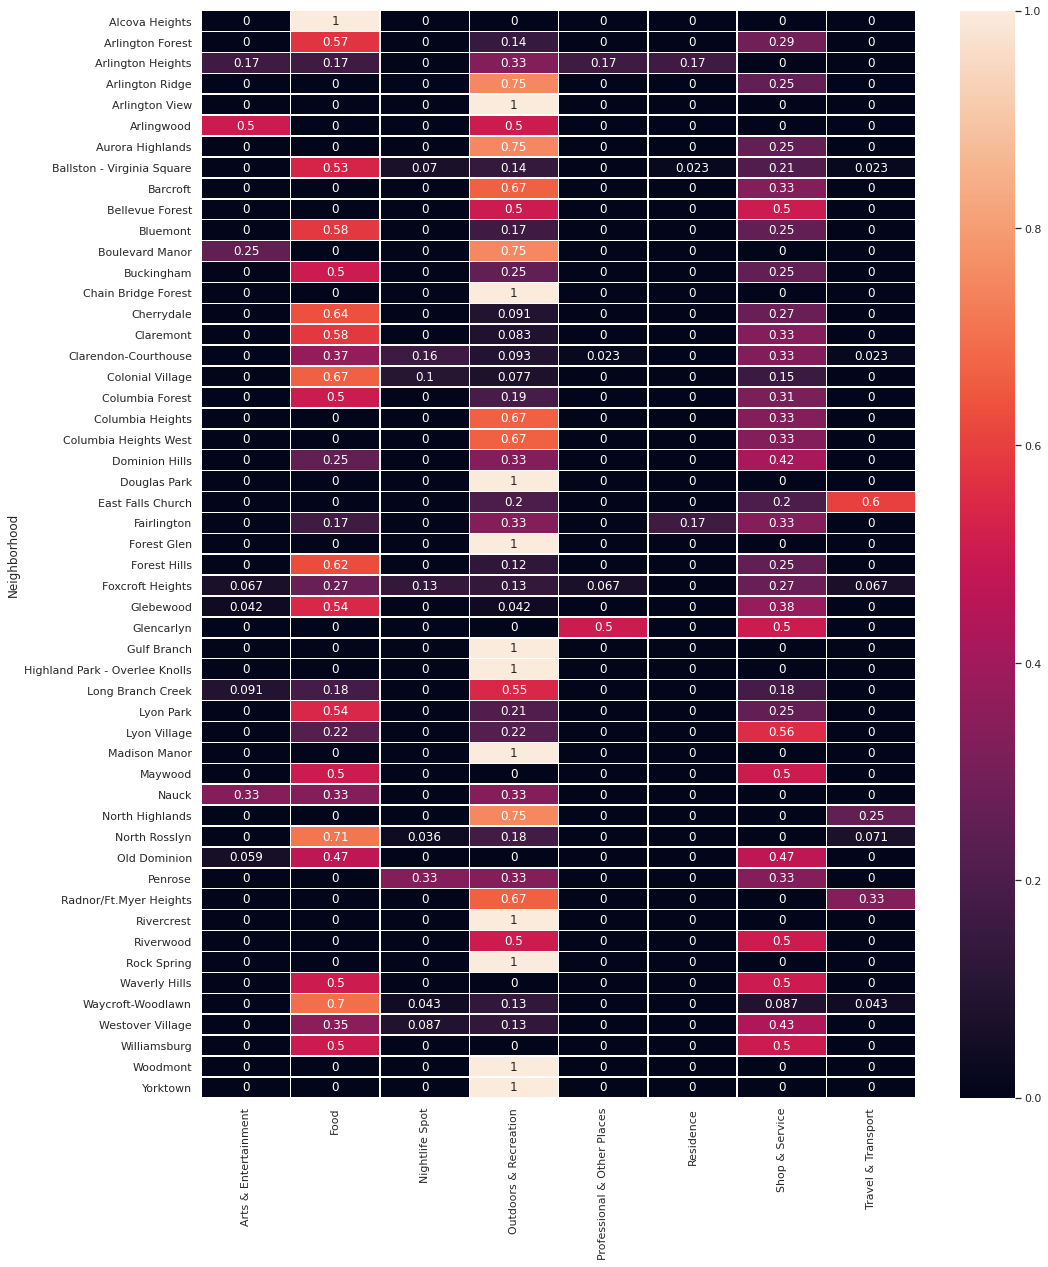

In [34]:
fig, ax = plt.subplots(figsize=(16, 20))
sns.heatmap(ax=ax, data=neighborhood_venues_freq, annot=True, linewidths=.5, square=False)
plt.show()

Scale demographic total data

In [35]:
min_max_scaler = MinMaxScaler()
arlington_demographics_scaled = arlington_demographics.copy()
arlington_demographics_scaled[['TOTAL POPULATION', 'TOTAL HOUSEHOLDS', 'TOTAL HOUSING UNITS']] = min_max_scaler.fit_transform(arlington_demographics_scaled[['TOTAL POPULATION', 'TOTAL HOUSEHOLDS', 'TOTAL HOUSING UNITS']])

arlington_demographics_scaled

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units
Alcova Heights,0.129736,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,0.085536,0.580,0.420,0.083721,0.950,0.050
Arlington Forest,0.153451,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.096427,0.685,0.315,0.091435,0.979,0.021
Arlington Heights,0.177827,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.120656,0.529,0.471,0.116166,0.964,0.036
Arlington Ridge,0.454552,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.428659,0.352,0.648,0.420760,0.945,0.055
Arlington View,0.062115,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.040382,0.598,0.402,0.039138,0.962,0.038
Arlingwood,0.017107,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.011013,0.809,0.191,0.011571,0.919,0.081
Ashton Heights,0.281131,0.049,0.108,0.111,0.281,0.142,0.126,0.112,0.048,0.017,0.007,0.204234,0.451,0.549,0.196370,0.965,0.035
Aurora Highlands,0.630837,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.582232,0.297,0.703,0.620306,0.871,0.129
Ballston - Virginia Square,1.000000,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,1.000000,0.240,0.760,1.000000,0.927,0.073
Barcroft,0.245521,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.151615,0.602,0.398,0.145320,0.968,0.032


#### Merge the Venue Category Frequency with the neighborhood Demographics

The data tables are inner joined to drop any neighborhood missing either demographic data or venue freq data

In [36]:
clustering_data = pd.concat([arlington_demographics_scaled, neighborhood_venues_freq], axis=1, join="inner")
clustering_data.fillna(0, inplace=True)
# Drop Neighborhood Index
clustering_data = clustering_data.reset_index(drop=True)
clustering_data

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,0.129736,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,0.085536,0.580,0.420,0.083721,0.950,0.050,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.153451,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,0.096427,0.685,0.315,0.091435,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000
2,0.177827,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,0.120656,0.529,0.471,0.116166,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000
3,0.454552,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,0.428659,0.352,0.648,0.420760,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
4,0.062115,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,0.040382,0.598,0.402,0.039138,0.962,0.038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
5,0.017107,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,0.011013,0.809,0.191,0.011571,0.919,0.081,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000
6,0.630837,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,0.582232,0.297,0.703,0.620306,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000
7,1.000000,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,1.000000,0.240,0.760,1.000000,0.927,0.073,0.000000,0.534884,0.069767,0.139535,0.000000,0.023256,0.209302,0.023256
8,0.245521,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,0.151615,0.602,0.398,0.145320,0.968,0.032,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,0.000000
9,0.066814,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,0.042340,0.796,0.204,0.040386,0.975,0.025,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000


In [37]:
clustering_data.describe()

,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.246696,0.062404,0.128000,0.078808,0.211481,0.155481,0.136635,0.116077,0.060135,0.032615,0.018288,0.196252,0.549385,0.450615,0.194452,0.950308,0.049692,0.029001,0.249465,0.018614,0.441914,0.014550,0.006857,0.212456,0.027143
std,0.221659,0.016658,0.058042,0.032289,0.123692,0.021278,0.028314,0.036420,0.028109,0.022832,0.016287,0.208994,0.184475,0.184475,0.210657,0.024823,0.024823,0.091347,0.279764,0.056618,0.367952,0.072997,0.032434,0.188220,0.099786
min,0.012922,0.026000,0.025000,0.026000,0.030000,0.101000,0.082000,0.055000,0.018000,0.006000,0.000000,0.009178,0.215000,0.143000,0.009189,0.871000,0.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.086252,0.051000,0.088500,0.049000,0.108750,0.142750,0.120000,0.088750,0.041000,0.016750,0.007750,0.053384,0.386500,0.276500,0.050822,0.940750,0.032750,0.000000,0.000000,0.000000,0.130435,0.000000,0.000000,0.000000,0.000000
50%,0.178377,0.066000,0.132000,0.076000,0.212000,0.156500,0.138500,0.112500,0.054500,0.026000,0.013500,0.124633,0.562500,0.437500,0.120703,0.957000,0.043000,0.000000,0.166667,0.000000,0.333333,0.000000,0.000000,0.250000,0.000000
75%,0.349119,0.074000,0.181500,0.100500,0.292250,0.169750,0.154250,0.133250,0.072000,0.044000,0.021250,0.274627,0.723500,0.613500,0.266307,0.967250,0.059250,0.000000,0.500000,0.000000,0.750000,0.000000,0.000000,0.333333,0.000000
max,1.000000,0.101000,0.222000,0.158000,0.477000,0.199000,0.199000,0.220000,0.181000,0.123000,0.085000,1.000000,0.857000,0.785000,1.000000,0.984000,0.129000,0.500000,1.000000,0.333333,1.000000,0.500000,0.166667,0.555556,0.600000


### 8) Kmeans Clustering 

#### Determine the Number of Cluster (Elbow Method)

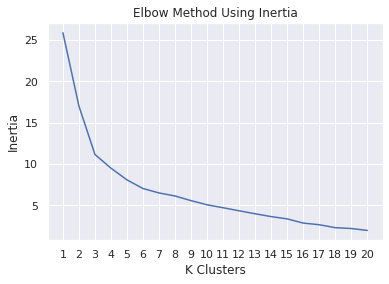

In [38]:
max_clusters = 20

inertias = []
for k in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(clustering_data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, max_clusters+1), inertias)
plt.title("Elbow Method Using Inertia")
plt.ylabel("Inertia")
plt.xlabel("K Clusters")
plt.xticks(ticks=range(1, max_clusters+1))
plt.show()

Base on the elbow method 6 is determined to be the optimal number of cluster

In [39]:
kclusters = 7

#### KMeans Clustering 

In [40]:
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=10).fit(clustering_data)

Create Data frame of Clusted Neighborhoods

In [41]:
arlington_neighborhoods_clusters = pd.concat([arlington_neighborhoods_location, arlington_demographics, neighborhood_venues_freq], axis=1, join="inner")
arlington_neighborhoods_clusters = pd.concat([arlington_neighborhoods_clusters, nearby_food_truck_count], axis=1, join="outer")
arlington_neighborhoods_clusters.fillna(0, inplace=True)
arlington_neighborhoods_clusters.insert(0, 'Cluster Labels', kmeans.labels_)
arlington_neighborhoods_clusters

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Alcova Heights,0,38.864557,-77.097201,1900,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Arlington Forest,0,38.868856,-77.113084,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.000000,0.000000,0.285714,0.000000,0.0
Arlington Heights,6,38.869557,-77.092201,2555,0.079,0.108,0.063,0.213,0.194,0.147,0.113,0.057,0.016,0.009,1032,0.529,0.471,1070,0.964,0.036,0.166667,0.166667,0.000000,0.333333,0.166667,0.166667,0.000000,0.000000,0.0
Arlington Ridge,5,38.853570,-77.067980,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Arlington View,1,38.863079,-77.072591,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
Arlingwood,3,38.927611,-77.121923,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.0
Aurora Highlands,2,38.854200,-77.061060,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Ballston - Virginia Square,2,38.882475,-77.107412,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073,0.000000,0.534884,0.069767,0.139535,0.000000,0.023256,0.209302,0.023256,1.0
Barcroft,3,38.862010,-77.110440,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.333333,0.000000,0.0
Bellevue Forest,3,38.914278,-77.113590,1043,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,392,0.796,0.204,402,0.975,0.025,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.0


Map of Clusters

In [42]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for neigh, lat, lng, cluster in zip(arlington_neighborhoods_clusters.index, arlington_neighborhoods_clusters['Latitude'], arlington_neighborhoods_clusters['Longitude'], arlington_neighborhoods_clusters['Cluster Labels']):
    label = folium.Popup(str(neigh) + ' Cluster ' + str(int(cluster)+1), parse_html=True)
    folium.CircleMarker(
        [lat, lng], 
        radius=5, 
        popup=label, 
        color=rainbow[int(cluster)-1], 
        fill=True, 
        fill_color=rainbow[int(cluster)-1], 
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

### 9) Explore The Clusters

In [43]:
clusters = []
for cluster in range(kclusters):
    clusters.append(arlington_neighborhoods_clusters[arlington_neighborhoods_clusters['Cluster Labels'] == cluster])

In [44]:
clusters[0]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Alcova Heights,0,38.864557,-77.097201,1900,0.075,0.116,0.078,0.205,0.169,0.163,0.121,0.047,0.019,0.006,745,0.580,0.420,784,0.950,0.050,0.000000,1.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
Arlington Forest,0,38.868856,-77.113084,2223,0.101,0.155,0.054,0.125,0.196,0.145,0.122,0.069,0.021,0.012,834,0.685,0.315,852,0.979,0.021,0.000000,0.571429,0.000000,0.142857,0.0,0.0,0.285714,0.000000,0.0
Cherrydale,0,38.872160,-77.108720,3169,0.068,0.138,0.075,0.157,0.157,0.135,0.125,0.074,0.045,0.026,1178,0.570,0.430,1225,0.962,0.038,0.000000,0.636364,0.000000,0.090909,0.0,0.0,0.272727,0.000000,0.0
Claremont,0,38.843168,-77.104701,2008,0.080,0.124,0.076,0.198,0.165,0.152,0.118,0.047,0.027,0.013,746,0.615,0.385,769,0.970,0.030,0.000000,0.583333,0.000000,0.083333,0.0,0.0,0.333333,0.000000,0.0
Columbia Forest,0,38.854001,-77.110257,3793,0.074,0.109,0.106,0.252,0.173,0.129,0.089,0.041,0.017,0.009,1603,0.518,0.482,1776,0.903,0.097,0.000000,0.500000,0.000000,0.187500,0.0,0.0,0.312500,0.000000,0.0
Forest Hills,0,38.869520,-77.117990,309,0.045,0.068,0.032,0.074,0.113,0.126,0.220,0.181,0.123,0.016,158,0.563,0.437,167,0.946,0.054,0.000000,0.625000,0.000000,0.125000,0.0,0.0,0.250000,0.000000,0.0
Glebewood,0,38.897955,-77.124437,840,0.062,0.090,0.080,0.220,0.144,0.135,0.101,0.060,0.049,0.060,370,0.457,0.543,385,0.961,0.039,0.041667,0.541667,0.000000,0.041667,0.0,0.0,0.375000,0.000000,0.0
Maywood,0,38.897369,-77.100248,1121,0.070,0.146,0.076,0.169,0.174,0.139,0.148,0.052,0.016,0.010,444,0.624,0.376,461,0.963,0.037,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.0
Old Dominion,0,38.900110,-77.124560,1550,0.063,0.188,0.060,0.108,0.168,0.152,0.131,0.072,0.035,0.022,550,0.725,0.275,566,0.972,0.028,0.058824,0.470588,0.000000,0.000000,0.0,0.0,0.470588,0.000000,0.0
Waverly Hills,0,38.895930,-77.118170,3809,0.063,0.122,0.092,0.223,0.164,0.142,0.100,0.048,0.027,0.019,1700,0.462,0.538,1772,0.959,0.041,0.000000,0.500000,0.000000,0.000000,0.0,0.0,0.500000,0.000000,0.0


In [45]:
clusters[1]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington View,1,38.863079,-77.072591,979,0.066,0.144,0.076,0.183,0.160,0.138,0.109,0.059,0.044,0.020,376,0.598,0.402,391,0.962,0.038,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Boulevard Manor,1,38.870070,-77.135870,1828,0.068,0.159,0.068,0.109,0.142,0.135,0.112,0.063,0.058,0.085,678,0.640,0.360,713,0.951,0.049,0.25,0.0,0.0,0.75,0.0,0.0,0.0,0.0,0.0
Chain Bridge Forest,1,38.930289,-77.112141,528,0.044,0.222,0.044,0.030,0.114,0.155,0.178,0.093,0.085,0.036,194,0.825,0.175,202,0.960,0.040,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Forest Glen,1,38.859140,-77.121410,924,0.044,0.132,0.096,0.213,0.169,0.163,0.100,0.058,0.015,0.009,402,0.448,0.552,420,0.957,0.043,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Gulf Branch,1,38.921157,-77.117225,919,0.063,0.220,0.036,0.048,0.138,0.182,0.178,0.076,0.042,0.016,334,0.796,0.204,349,0.957,0.043,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Highland Park - Overlee Knolls,1,38.887751,-77.147063,1692,0.074,0.191,0.047,0.113,0.176,0.163,0.133,0.068,0.020,0.014,607,0.727,0.273,627,0.968,0.032,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Madison Manor,1,38.880390,-77.147202,1370,0.073,0.186,0.052,0.120,0.172,0.150,0.134,0.053,0.042,0.019,495,0.749,0.251,505,0.980,0.020,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Rivercrest,1,38.922056,-77.119145,344,0.058,0.180,0.026,0.055,0.131,0.195,0.151,0.113,0.038,0.052,126,0.857,0.143,128,0.984,0.016,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Rock Spring,1,38.910490,-77.141090,2850,0.066,0.220,0.045,0.065,0.144,0.175,0.148,0.074,0.045,0.019,996,0.801,0.199,1024,0.973,0.027,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0
Woodmont,1,38.900667,-77.094978,883,0.072,0.189,0.048,0.077,0.145,0.180,0.148,0.068,0.040,0.033,303,0.782,0.218,324,0.935,0.065,0.00,0.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0


In [46]:
clusters[2]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Aurora Highlands,2,38.854200,-77.061060,8725,0.044,0.043,0.105,0.361,0.151,0.106,0.084,0.053,0.033,0.019,4804,0.297,0.703,5514,0.871,0.129,0.0,0.000000,0.000000,0.750000,0.000000,0.000000,0.250000,0.000000,0.0
Ballston - Virginia Square,2,38.882475,-77.107412,13753,0.027,0.025,0.138,0.433,0.134,0.082,0.070,0.037,0.027,0.026,8218,0.240,0.760,8861,0.927,0.073,0.0,0.534884,0.069767,0.139535,0.000000,0.023256,0.209302,0.023256,1.0
Clarendon-Courthouse,2,38.891076,-77.091643,8722,0.043,0.038,0.105,0.477,0.175,0.082,0.055,0.018,0.006,0.002,5081,0.269,0.731,5403,0.940,0.060,0.0,0.372093,0.162791,0.093023,0.023256,0.000000,0.325581,0.023256,0.0
Fairlington,2,38.832971,-77.090225,8137,0.074,0.058,0.045,0.323,0.199,0.117,0.118,0.045,0.017,0.004,4574,0.376,0.624,4766,0.960,0.040,0.0,0.166667,0.000000,0.333333,0.000000,0.166667,0.333333,0.000000,1.0
Radnor/Ft.Myer Heights,2,38.883231,-77.076931,11453,0.032,0.034,0.150,0.424,0.146,0.093,0.069,0.035,0.014,0.004,6637,0.254,0.746,7289,0.911,0.089,0.0,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,0.0


In [47]:
clusters[3]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlingwood,3,38.927611,-77.121923,366,0.066,0.208,0.036,0.033,0.101,0.169,0.183,0.101,0.063,0.041,136,0.809,0.191,148,0.919,0.081,0.5,0.00,0.0,0.500000,0.0,0.0,0.000000,0.0,0.0
Barcroft,3,38.862010,-77.110440,3477,0.081,0.126,0.097,0.228,0.157,0.139,0.100,0.041,0.020,0.010,1285,0.602,0.398,1327,0.968,0.032,0.0,0.00,0.0,0.666667,0.0,0.0,0.333333,0.0,0.0
Bellevue Forest,3,38.914278,-77.113590,1043,0.051,0.206,0.039,0.035,0.134,0.199,0.189,0.072,0.053,0.021,392,0.796,0.204,402,0.975,0.025,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0
Dominion Hills,3,38.875945,-77.141091,1695,0.079,0.195,0.049,0.117,0.174,0.162,0.125,0.050,0.027,0.022,599,0.723,0.277,613,0.977,0.023,0.0,0.25,0.0,0.333333,0.0,0.0,0.416667,0.0,0.0
Riverwood,3,38.905389,-77.102479,488,0.078,0.191,0.033,0.043,0.139,0.154,0.176,0.105,0.053,0.029,174,0.787,0.213,185,0.941,0.059,0.0,0.00,0.0,0.500000,0.0,0.0,0.500000,0.0,0.0


In [48]:
clusters[4]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Bluemont,4,38.878230,-77.121060,5850,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,2300,0.519,0.481,2392,0.962,0.038,0.0,0.583333,0.000000,0.166667,0.0,0.0,0.250000,0.000000,0.0
Buckingham,4,38.872160,-77.109950,5732,0.052,0.095,0.109,0.267,0.142,0.105,0.092,0.059,0.048,0.030,2861,0.320,0.680,3063,0.934,0.066,0.0,0.500000,0.000000,0.250000,0.0,0.0,0.250000,0.000000,0.0
Colonial Village,4,38.892392,-77.080983,2570,0.026,0.030,0.124,0.455,0.162,0.086,0.065,0.036,0.013,0.004,1621,0.215,0.785,1700,0.954,0.046,0.0,0.666667,0.102564,0.076923,0.0,0.0,0.153846,0.000000,5.0
Lyon Park,4,38.880436,-77.089853,4862,0.051,0.089,0.115,0.345,0.154,0.111,0.078,0.037,0.013,0.007,2370,0.368,0.632,2526,0.938,0.062,0.0,0.541667,0.000000,0.208333,0.0,0.0,0.250000,0.000000,2.0
North Rosslyn,4,38.896017,-77.071553,2536,0.028,0.026,0.158,0.377,0.142,0.093,0.086,0.064,0.021,0.006,1442,0.299,0.701,1564,0.922,0.078,0.0,0.714286,0.035714,0.178571,0.0,0.0,0.000000,0.071429,0.0


In [49]:
clusters[5]

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Arlington Ridge,5,38.853570,-77.067980,6324,0.036,0.061,0.081,0.290,0.149,0.114,0.125,0.080,0.044,0.020,3549,0.352,0.648,3755,0.945,0.055,0.000000,0.000000,0.0,0.750000,0.0,0.0,0.250000,0.00,0.0
Columbia Heights,5,38.857612,-77.121090,4985,0.058,0.063,0.098,0.340,0.175,0.120,0.088,0.035,0.018,0.006,2842,0.309,0.691,2994,0.949,0.051,0.000000,0.000000,0.0,0.666667,0.0,0.0,0.333333,0.00,0.0
Columbia Heights West,5,38.857612,-77.121090,7398,0.087,0.175,0.096,0.211,0.172,0.130,0.077,0.035,0.013,0.004,2551,0.615,0.385,2638,0.967,0.033,0.000000,0.000000,0.0,0.666667,0.0,0.0,0.333333,0.00,0.0
Douglas Park,5,38.853087,-77.097329,9365,0.068,0.134,0.089,0.246,0.187,0.138,0.081,0.036,0.015,0.006,3689,0.562,0.438,3987,0.925,0.075,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.000000,0.00,0.0
Long Branch Creek,5,38.849831,-77.074681,4024,0.062,0.084,0.113,0.389,0.166,0.098,0.055,0.020,0.009,0.004,2044,0.365,0.635,2313,0.884,0.116,0.090909,0.181818,0.0,0.545455,0.0,0.0,0.181818,0.00,1.0
Nauck,5,38.847535,-77.087774,5738,0.064,0.132,0.105,0.260,0.151,0.128,0.086,0.039,0.025,0.010,2287,0.520,0.480,2398,0.954,0.046,0.333333,0.333333,0.0,0.333333,0.0,0.0,0.000000,0.00,0.0
North Highlands,5,38.898167,-77.083033,3032,0.044,0.037,0.138,0.428,0.135,0.086,0.073,0.040,0.014,0.005,1758,0.262,0.738,1852,0.949,0.051,0.000000,0.000000,0.0,0.750000,0.0,0.0,0.000000,0.25,0.0


Number of Food Trucks nearby each of the clusters

In [50]:
arlington_neighborhoods_clusters[['Cluster Labels', 'Food Truck Count']].groupby('Cluster Labels').sum()

,Food Truck Count
Cluster Labels,
0,2.0
1,0.0
2,2.0
3,0.0
4,7.0
5,1.0
6,0.0


## D. Results

Explore attributes of each cluster

In [51]:
clusters_df = arlington_neighborhoods_clusters.groupby('Cluster Labels').mean().reset_index()
clusters_df['Food Truck Count'] = arlington_neighborhoods_clusters[['Cluster Labels', 'Food Truck Count']].groupby('Cluster Labels').sum()
clusters_df

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
0,0,38.878919,-77.116102,2099.083333,0.072083,0.134333,0.070250,0.162833,0.161250,0.144500,0.127333,0.069667,0.038667,0.018750,827.666667,0.603000,0.397000,867.833333,0.958667,0.041333,0.008374,0.593669,0.003623,0.066808,0.000000,0.000000,0.323902,0.003623,2.0
1,1,38.895242,-77.122663,1448.454545,0.064000,0.185182,0.054000,0.100909,0.149727,0.163091,0.139818,0.071091,0.042818,0.029091,526.363636,0.725545,0.274455,545.636364,0.963364,0.036636,0.022727,0.000000,0.000000,0.977273,0.000000,0.000000,0.000000,0.000000,0.0
2,2,38.868790,-77.085454,10158.000000,0.044000,0.039600,0.108600,0.403600,0.161000,0.096000,0.079200,0.037600,0.019400,0.011000,5862.800000,0.287200,0.712800,6366.600000,0.921800,0.078200,0.000000,0.214729,0.046512,0.396512,0.004651,0.037984,0.223643,0.075969,2.0
3,3,38.897047,-77.117904,1413.800000,0.071000,0.185200,0.050800,0.091200,0.141000,0.164600,0.154600,0.073800,0.043200,0.024600,517.200000,0.743400,0.256600,535.000000,0.956000,0.044000,0.100000,0.050000,0.000000,0.500000,0.000000,0.000000,0.350000,0.000000,0.0
4,4,38.883847,-77.094680,4310.000000,0.044800,0.071600,0.121000,0.340200,0.150200,0.103800,0.084600,0.048800,0.023600,0.011600,2118.800000,0.344200,0.655800,2249.000000,0.942000,0.058000,0.000000,0.601190,0.027656,0.176099,0.000000,0.000000,0.180769,0.014286,7.0
5,5,38.859631,-77.093283,5838.000000,0.059857,0.098000,0.102857,0.309143,0.162143,0.116286,0.083571,0.040714,0.019714,0.007857,2674.285714,0.426429,0.573571,2848.142857,0.939000,0.061000,0.060606,0.073593,0.000000,0.673160,0.000000,0.000000,0.156926,0.035714,1.0
6,6,38.876377,-77.109714,2891.285714,0.065429,0.119857,0.077000,0.227714,0.158143,0.134429,0.113286,0.060429,0.027429,0.016429,1264.571429,0.498857,0.501143,1345.571429,0.949000,0.051000,0.033333,0.143340,0.079089,0.193237,0.104762,0.023810,0.327191,0.095238,0.0


Identify the Cluster with the most nearby food trucks 

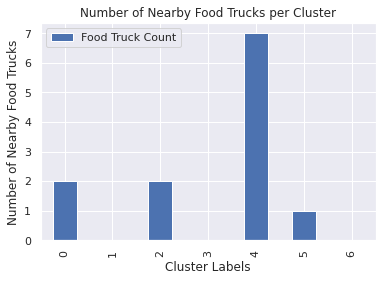

In [52]:
ax = clusters_df.plot.bar(x='Cluster Labels', y='Food Truck Count')
ax.set_title("Number of Nearby Food Trucks per Cluster")
ax.set_ylabel("Number of Nearby Food Trucks")
plt.show()

Identify the Neighborhoods in the cluster with the most nearby food trucks

In [56]:
solution_cluster = clusters[4]
list(solution_cluster.index)

['Bluemont', 'Buckingham', 'Colonial Village', 'Lyon Park', 'North Rosslyn']

Get potential solution neighborhoods (neighborhoods in the clutser with the most nearby food trucks yet without any nearby)

In [57]:
nearby_food_truck_count.index
potential_solutions = solution_cluster.loc[~solution_cluster.index.isin(nearby_food_truck_count.index)]
potential_solutions

,Cluster Labels,Latitude,Longitude,TOTAL POPULATION,Under 5 years,5 to 17 years,18 to 24 years,25 to 34 years,35 to 44 years,45 to 54 years,55 to 64 years,65 to 74 years,75 to 84 years,85 years and over,TOTAL HOUSEHOLDS,family households,nonfamily households,TOTAL HOUSING UNITS,occupied housing units,vacant housing units,Arts & Entertainment,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,Food Truck Count
Bluemont,4,38.878230,-77.121060,5850,0.067,0.118,0.099,0.257,0.151,0.124,0.102,0.048,0.023,0.011,2300,0.519,0.481,2392,0.962,0.038,0.0,0.583333,0.000000,0.166667,0.0,0.0,0.25,0.000000,0.0
Buckingham,4,38.872160,-77.109950,5732,0.052,0.095,0.109,0.267,0.142,0.105,0.092,0.059,0.048,0.030,2861,0.320,0.680,3063,0.934,0.066,0.0,0.500000,0.000000,0.250000,0.0,0.0,0.25,0.000000,0.0
North Rosslyn,4,38.896017,-77.071553,2536,0.028,0.026,0.158,0.377,0.142,0.093,0.086,0.064,0.021,0.006,1442,0.299,0.701,1564,0.922,0.078,0.0,0.714286,0.035714,0.178571,0.0,0.0,0.00,0.071429,0.0


Check the correlation of neighborhood attributes to Number of food trucks nearby each cluster

In [58]:
_corr = clusters_df.corr()
_corr["Food Truck Count"].sort_values(ascending=False)

Food Truck Count               1.000000
Food                           0.794827
18 to 24 years                 0.738917
nonfamily households           0.596387
25 to 34 years                 0.558922
Longitude                      0.504977
vacant housing units           0.335541
TOTAL POPULATION               0.259734
TOTAL HOUSEHOLDS               0.254361
TOTAL HOUSING UNITS            0.250050
Nightlife Spot                 0.054051
Cluster Labels                 0.030890
35 to 44 years                 0.005665
Shop & Service                -0.086303
Latitude                      -0.087871
Residence                     -0.127994
Travel & Transport            -0.155001
Professional & Other Places   -0.302366
occupied housing units        -0.335541
65 to 74 years                -0.409776
75 to 84 years                -0.422630
Outdoors & Recreation         -0.474743
85 years and over             -0.485106
55 to 64 years                -0.558416
Arts & Entertainment          -0.558916


## E. Discussion

As mentioned the purpose of this project was to explore Arlington County neighborhoods in order to find neighborhoods that could provide potentially successful food truck locations.  In order to determine possible solution neighborhoods, we clustered the neighborhoods, using the K-Means algorithm, based on their basic demographics and types or categories of nearby venues.  

Once clustered we can assume that if a single cluster has a much greater number of nearby food trucks in comparison to the other clusters, then the cluster has attributes that are favorable to food trucks.

Comparing the feature of each cluster can give us also provide us with an understanding of what features a neighborhood needs in order to be potentially successful food truck location. 

As a result of the clustering it can determined that there are three neighborhoods that provide a good solution Bluemont, Buckingham, and North Rosslyn. 

Each of these neighborhoods have a high frequency of food venues nearby as well as a young demographic, mainly 18-34 living, and lastly contains mostly non-family households.


## F. Conclusion

In this project, I analyzed Arlington County, Virginia neighborhoods in order to determine potential new neighborhoods for food truck venues. I build a clustering model that groups neighborhoods base on their demographics as well as categories of nearby venues. The clusters can be useful in determining features that different neighborhoods. Additionally, the clustering can be used to determined features that make preferable food truck locations.